# Classification

We can model a classifier for $C$ classes with $N$ features using an $(N+1)$-dimensional compressed tensor: the first $N$ dimensions capture all possible feature values, whereas the last one has size $C$ and is used to compute class probabilities.

Here we will try a simple $2$-class example in $N = 2$, the Swiss roll classification problem.

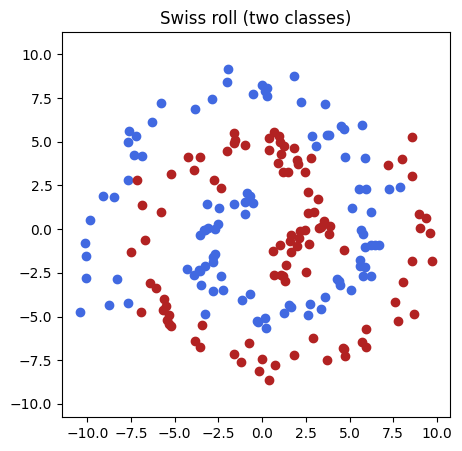

In [1]:
import tntorch as tn
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

N = 2
C = 2  # Number of classes
P = 100  # Points per class
c0 = torch.rand(P)*8+2
#print(c0)
c0 = c0[:, None]
#print(c0)

c0 = torch.cat([c0*torch.cos(c0), c0*torch.sin(c0)], dim=1)
c1 = torch.rand(P)*8+2
c1 = c1[:, None]
c1 = torch.cat([-c1*torch.cos(c1), -c1*torch.sin(c1)], dim=1)
#c1 = -c0
c0 += torch.randn(*c0.shape)/1.5
c1 += torch.randn(*c1.shape)/1.5
#print(c1 == -c0)

plt.figure(figsize=(5, 5))
plt.scatter(c0[:, 0], c0[:, 1], color='royalblue')
plt.scatter(c1[:, 0], c1[:, 1], color='firebrick')
plt.gca().set_aspect('equal', 'datalim')
plt.title('Swiss roll (two classes)')
plt.show()

In [2]:
# Assemble (X, y) data set
X = torch.cat([c0, c1], dim=0)
y = torch.cat([torch.zeros(len(c0)), torch.ones(len(c1))])

# Shuffle data
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Discretize features into [0, 1, ..., nticks-1]
nticks = 128
X = (X-X.min()) / (X.max()-X.min())
#print(X)
X = X*(nticks-1)
#print(X)
# Split into 75% train / 25% test
ntrain = int(len(X)*0.75)
X_train = X[:ntrain, :].long()
y_train = y[:ntrain].long()
X_test = X[ntrain:, :].long()
y_test = y[ntrain:].long()

In [3]:
print(X.shape)

torch.Size([200, 2])


Let's set up the $128 \times 128 \times 2$ tensor that will be optimized. 

In [4]:
t = tn.rand([nticks]*N + [C], ranks_tt=10,ranks_tucker= 6 ,  requires_grad=True)
t.set_factors('dct', dim=range(N))
t

3D TT-Tucker tensor:

 128 128  2
  |   |   |
  6   6   6
 (0) (1) (2)
 / \ / \ / \
1   10  10  1

Our tensor's last dimension is $2$: for each feature $(x_1, x_2)$ it produces $2$ numbers, one per class. For classification we will transform these weights into probabilities using the softmax function:

In [5]:
def softmax(x):
    expx = torch.exp(x-x.max())
    return expx / torch.sum(expx, dim=-1, keepdim=True)

To assess the goodness of a matrix of probabilities (rows are instances, columns are classes) we use the cross-entropy loss:

In [6]:
def cross_entropy_loss(probs, y):
    return torch.mean(-torch.log(probs[np.arange(len(probs)), y]))

We are now ready to fit our tensor network:

In [7]:
def loss(t):
    return cross_entropy_loss(softmax(t[X_train].torch()), y_train)
tn.optimize(t, loss)

iter: 0       | loss:   0.694290 | total time:    0.0400
iter: 500     | loss:   0.070777 | total time:    1.4982
iter: 1000    | loss:   0.013217 | total time:    2.4398
iter: 1500    | loss:   0.003628 | total time:    3.5357
iter: 2000    | loss:   0.001423 | total time:    4.8747
iter: 2500    | loss:   0.000693 | total time:    6.2740
iter: 3000    | loss:   0.000383 | total time:    7.8862
iter: 3500    | loss:   0.000229 | total time:    9.1988
iter: 4000    | loss:   0.000145 | total time:   10.3440
iter: 4436    | loss:   0.000100 | total time:   11.2776 <- converged (tol=0.0001)


We now predict classes for the test instances and compute the *score* (#correctly classified / number of test instances):

In [8]:
prediction = torch.max(t[X_test].torch(), dim=1)[1]
score = torch.sum(prediction == y_test).double() / len(y_test)
print('Score:', score)

Score: tensor(0.8400)


Finally, we will show the class probabilities for the whole feature space (blue is class `0`, red is class `1`):

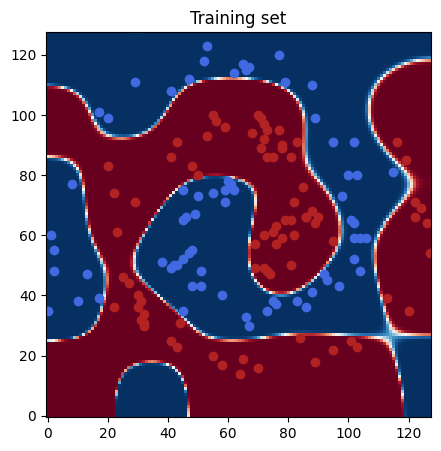

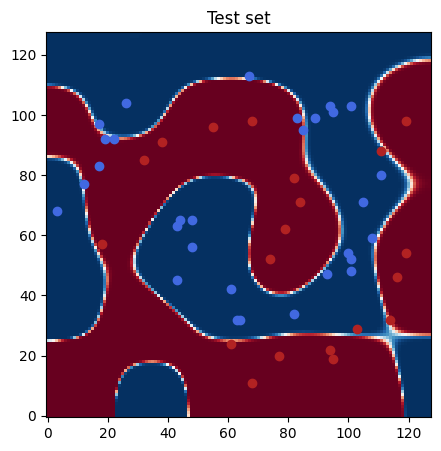

In [9]:
fig = plt.figure(figsize=(5, 5))
plt.title('Training set')
plt.imshow(softmax(t.torch())[..., 0].detach().numpy().T, origin='lower', cmap='RdBu')
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], color='royalblue')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='firebrick')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.title('Test set')
plt.imshow(softmax(t.torch())[..., 0].detach().numpy().T, origin='lower', cmap='RdBu')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], color='royalblue')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='firebrick')
plt.show()

# Compare with traditional algrithm : SVM

In [10]:
# Map y to -1, +1 for SVM
y_train_svm = y_train.clone()
y_train_svm[y_train_svm == 0] = -1
y_train_svm[y_train_svm == 1] = 1

y_test_svm = y_test.clone()
y_test_svm[y_test_svm == 0] = -1
y_test_svm[y_test_svm == 1] = 1


In [11]:

# Define RBF kernel function
def rbf_kernel(X1, X2, gamma):
    
    diff = X1.unsqueeze(1) - X2.unsqueeze(0)
    dist_sq = (diff**2).sum(dim=2)
    return torch.exp(-gamma * dist_sq)


In [12]:

# Choose a gamma parameter for the RBF kernel
gamma = 0.5  
C_value=5
# Compute kernel matrix for training data
K = rbf_kernel(X_train, X_train, gamma=gamma)


In [13]:

# SVM 

n = len(X_train)
y_train_svm = y_train_svm.to(torch.float64)
y_mat = y_train_svm.unsqueeze(1)*y_train_svm.unsqueeze(0)

# Initialize raw_alpha as a learnable parameter
raw_alpha = torch.zeros(n, requires_grad=True, dtype=torch.float64)

# Set up an optimizer (e.g. Adam)
optimizer = torch.optim.Adam([raw_alpha], lr=0.01)

# Training loop
num_iterations = 5000
for i in range(num_iterations):
    optimizer.zero_grad()
    alpha = C_value * torch.sigmoid(raw_alpha)  

    #
    obj = alpha.sum() - 0.5 * (alpha.unsqueeze(1)*alpha.unsqueeze(0)*y_mat*K).sum()
    loss = -obj  # minimize negative of the objective

    loss.backward()
    optimizer.step()

    if i % 1000 == 0:
        print(f"Iteration {i}, dual objective: {obj.item():.4f}")



Iteration 0, dual objective: -149.5003
Iteration 1000, dual objective: 69.0582
Iteration 2000, dual objective: 69.0878
Iteration 3000, dual objective: 69.0928
Iteration 4000, dual objective: 69.0937


In [14]:

alpha = C_value * torch.sigmoid(raw_alpha).detach()
sv_mask = (alpha > 1e-5) & (alpha < C_value - 1e-5)
if sv_mask.sum() == 0:
   
    sv_mask = (alpha > 1e-5)

if sv_mask.sum() > 0:
    # Take first such support vector
    sv_idx = torch.where(sv_mask)[0][0]
else:
    sv_idx = 0

b = y_train_svm[sv_idx] - (alpha*y_train_svm*K[sv_idx]).sum()

def decision_function(X_test):
    K_test = rbf_kernel(X_test, X_train, gamma=gamma)
    return (alpha*y_train_svm).matmul(K_test.T) + b

with torch.no_grad():
    y_pred = torch.sign(decision_function(X_test))
    accuracy = (y_pred == y_test_svm).float().mean().item()

print(f"Test accuracy: {accuracy*100:.2f}%")





Test accuracy: 80.00%


/Users/user/Desktop/codes/.venv/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


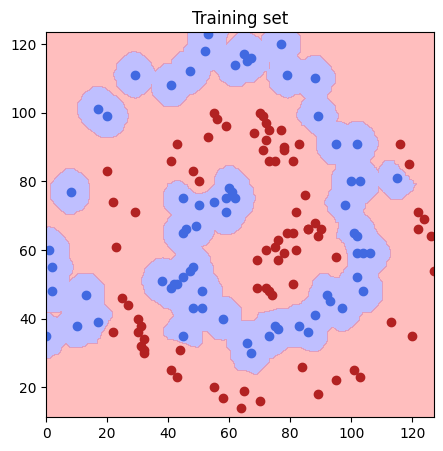

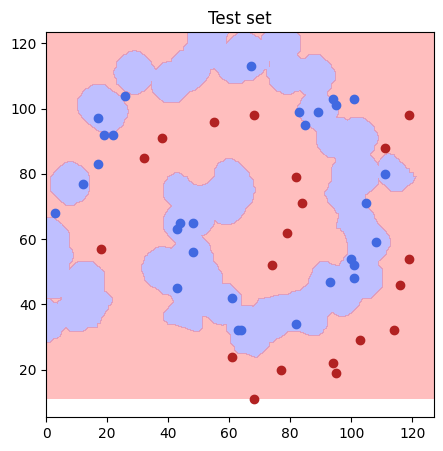

In [15]:
# Plot decision boundary 
xx, yy = torch.meshgrid(torch.linspace(X.min(dim=0)[0][0], X.max(dim=0)[0][0], 100),
                        torch.linspace(X.min(dim=0)[0][1], X.max(dim=0)[0][1], 100))

grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)
with torch.no_grad():
    Z = decision_function(grid_points).reshape(xx.shape)


fig = plt.figure(figsize=(5, 5))
plt.title('Training set')
plt.contourf(xx.numpy(), yy.numpy(), Z.numpy(), levels=[-1e9,0,1e9], alpha=0.5, cmap='bwr')
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], color='royalblue')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], color='firebrick')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.title('Test set')
plt.contourf(xx.numpy(), yy.numpy(), Z.numpy(), levels=[-1e9,0,1e9], alpha=0.5, cmap='bwr')
plt.scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], color='royalblue')
plt.scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], color='firebrick')
plt.show()


# Compare with traditional algrithm : full connected NN

In [16]:
X_train = X_train.to(torch.float64)
X_test = X_test.to(torch.float64)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)

# Assuming X_train, y_train, X_test, y_test are already defined
# Standardize the data: (X - mean) / std
mean = X_train.mean(dim=0, keepdim=True)
std = X_train.std(dim=0, keepdim=True) + 1e-7
X_train_std = (X_train - mean) / std
X_test_std = (X_test - mean) / std

y_train = y_train.long()
y_test = y_test.long()


In [18]:

# Define a larger MLP
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
        # Optional: Weight initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.softmax(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x  # raw logits


In [19]:
class Network(nn.Module):
    
    def __init__(self, input_size=2, hidden_size=64, output_size=2):
        super(Network, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l3(x)
        return F.log_softmax(x)


In [20]:
#model = MLP()
model = Network()
print(model)

Network(
  (l1): Linear(in_features=2, out_features=64, bias=True)
  (relu): ReLU()
  (l3): Linear(in_features=64, out_features=2, bias=True)
)


In [21]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 2000  # more epochs
batch_size = 32

def get_batches(X, y, batch_size):
    perm = torch.randperm(len(X))
    X = X[perm]
    y = y[perm]
    for i in range(0, len(X), batch_size):
        yield X[i:i+batch_size], y[i:i+batch_size]

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for Xb, yb in get_batches(X_train_std, y_train, batch_size):
        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(Xb)
    if (epoch+1) % 400 == 0:
        avg_loss = total_loss / len(X_train_std)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


/var/folders/9j/l5f2m88j573_gw21qqyrlcdm0000gn/T/ipykernel_98154/2623976750.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch 400/2000, Loss: 0.4729
Epoch 800/2000, Loss: 0.3395
Epoch 1200/2000, Loss: 0.2445
Epoch 1600/2000, Loss: 0.1805
Epoch 2000/2000, Loss: 0.1368


In [22]:

model.eval()
with torch.no_grad():
    train_logits = model(X_train_std)
    train_preds = train_logits.argmax(dim=1)
    train_accuracy = (train_preds == y_train).float().mean().item()

    test_logits = model(X_test_std)
    test_preds = test_logits.argmax(dim=1)
    test_accuracy = (test_preds == y_test).float().mean().item()

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Training Accuracy: 98.67%
Test Accuracy: 86.00%


/var/folders/9j/l5f2m88j573_gw21qqyrlcdm0000gn/T/ipykernel_98154/2623976750.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


/var/folders/9j/l5f2m88j573_gw21qqyrlcdm0000gn/T/ipykernel_98154/2623976750.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


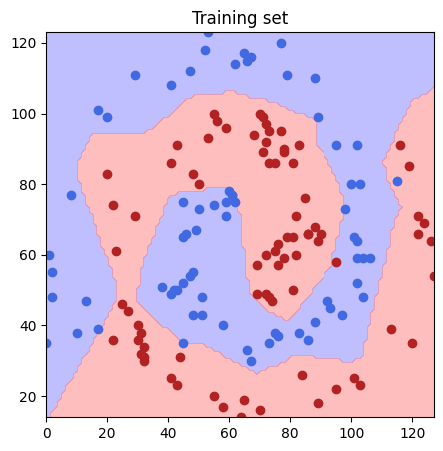

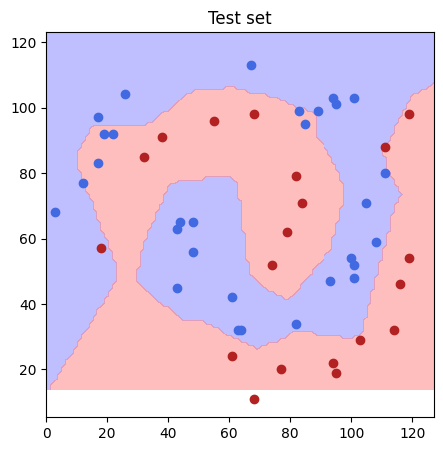

In [23]:

# Decision boundary
xx, yy = torch.meshgrid(
    torch.linspace(X_train[:,0].min(), X_train[:,0].max(), 100),
    torch.linspace(X_train[:,1].min(), X_train[:,1].max(), 100)
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)
grid_points_std = (grid_points - mean) / std

with torch.no_grad():
    Z_logits = model(grid_points_std)
    Z_preds = Z_logits.argmax(dim=1)
    Z = Z_preds.reshape(xx.shape)

fig = plt.figure(figsize=(5, 5))
plt.title('Training set')
plt.contourf(xx.numpy(), yy.numpy(), Z.numpy(), levels=[-1e9,0,1e9], alpha=0.5, cmap='bwr')
plt.scatter(X_train[y_train==0,0].numpy(), X_train[y_train==0,1].numpy(), color='royalblue')
plt.scatter(X_train[y_train==1,0].numpy(), X_train[y_train==1,1].numpy(), color='firebrick')
plt.show()

fig = plt.figure(figsize=(5, 5))
plt.title('Test set')
plt.contourf(xx.numpy(), yy.numpy(), Z.numpy(), levels=[-1e9,0,1e9], alpha=0.5, cmap='bwr')
plt.scatter(X_test[y_test==0,0].numpy(), X_test[y_test==0,1].numpy(), color='royalblue')
plt.scatter(X_test[y_test==1,0].numpy(), X_test[y_test==1,1].numpy(), color='firebrick')
plt.show()


# Application 1: Iris dataset 

In [24]:
from sklearn import datasets

iris = datasets.load_iris()

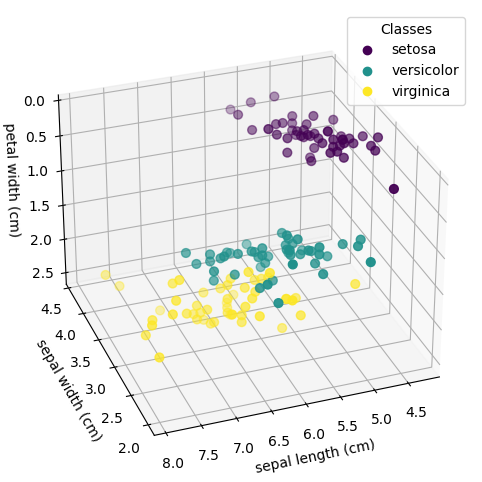

In [25]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
scatter = ax.scatter(
    iris.data[:, 0],
    iris.data[:, 1],
    iris.data[:, 3],
    c=iris.target,
    s=40,
)
ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="upper right", title="Classes"
)
ax.set(
    xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],zlabel=iris.feature_names[3]
);

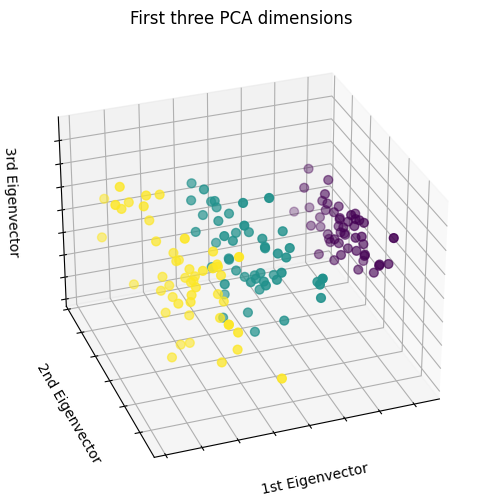

In [26]:
import mpl_toolkits.mplot3d  # no PCA result can be very bad

from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

X_reduced = PCA(n_components=3).fit_transform(iris.data)
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    X_reduced[:, 2],
    c=iris.target,
    s=40,
)

ax.set_title("First three PCA dimensions")
ax.set_xlabel("1st Eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd Eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd Eigenvector")
ax.zaxis.set_ticklabels([])

plt.show()

In [27]:
X=X_reduced
y=iris.target

idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# Discretize features into [0, 1, ..., nticks-1]
nticks = 128
X = (X-X.min()) / (X.max()-X.min())
#print(X)
X = X*(nticks-1)
print(X.shape)
# Split into 75% train / 25% test
ntrain = int(len(X)*0.75)
X_train = X[:ntrain, :]
y_train = y[:ntrain]
X_test = X[ntrain:, :]
y_test = y[ntrain:]

(150, 3)


In [28]:
N=3
C=3
nticks=128
t = tn.rand([nticks]*N + [C], ranks_tt=10, ranks_tucker=6, requires_grad=True)
t.set_factors('dct', dim=range(N))
t

4D TT-Tucker tensor:

 128 128 128  3
  |   |   |   |
  6   6   6   6
 (0) (1) (2) (3)
 / \ / \ / \ / \
1   10  10  10  1

In [29]:
def loss(t):
    return cross_entropy_loss(softmax(t[X_train].torch()), y_train)
tn.optimize(t, loss)

iter: 0       | loss:   1.075226 | total time:    0.0047
iter: 500     | loss:   0.383898 | total time:    1.1967
iter: 1000    | loss:   0.063776 | total time:    2.5441
iter: 1500    | loss:   0.053778 | total time:    3.7152
iter: 2000    | loss:   0.050658 | total time:    4.8596
iter: 2500    | loss:   0.046875 | total time:    6.1293
iter: 3000    | loss:   0.040515 | total time:    7.2885
iter: 3500    | loss:   0.030212 | total time:    8.4730
iter: 4000    | loss:   0.009714 | total time:    9.7494
iter: 4500    | loss:   0.001625 | total time:   10.8794
iter: 5000    | loss:   0.000490 | total time:   12.0185
iter: 5500    | loss:   0.000216 | total time:   13.2194
iter: 6000    | loss:   0.000115 | total time:   14.3374
iter: 6123    | loss:   0.000100 | total time:   14.6153 <- converged (tol=0.0001)


In [30]:
prediction = torch.max(t[X_test].torch(), dim=1)[1]

In [31]:
score = sum(np.array(prediction) == np.array(y_test)) / len(y_test)
print('Score:', score*100)

Score: 89.47368421052632


In [32]:
#print(X_test.shape);
x1_min, x1_max = X[:, 0].min() , X[:, 0].max() 
x2_min, x2_max = X[:, 1].min() , X[:, 1].max() 
x3_min, x3_max = X[:, 2].min() , X[:, 2].max() 
xx, yy,zz = np.meshgrid(np.linspace(x1_min, x1_max , 50),
                     np.linspace(x2_min, x2_max , 50),
                     np.linspace(x3_min, x3_max , 50))

grid=np.stack((xx.ravel(),yy.ravel(),zz.ravel()),axis=1)
print(grid.shape)

(125000, 3)


In [33]:
label = torch.max(t[grid].torch(), dim=1)[1]
label = label.reshape(xx.shape)
print(label.shape)

torch.Size([50, 50, 50])


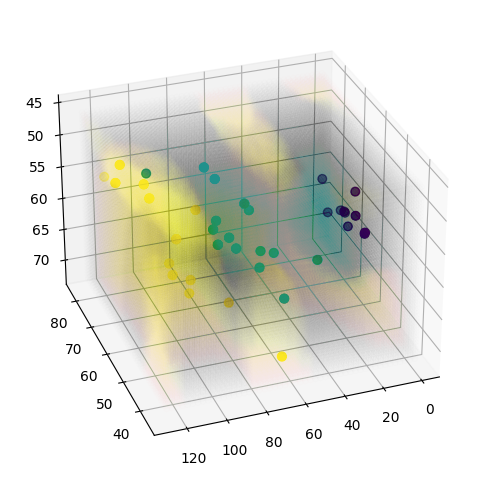

In [34]:
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)
from matplotlib.colors import ListedColormap
#region_cmap = ListedColormap(['y', 'g', 'p'])
ax.scatter3D(xx,yy,zz,c=label,alpha=0.005)
ax.scatter(
    X_test[:, 0],
    X_test[:, 1],
    X_test[:, 2],
    c=prediction,
    s=40,
)
